In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import os
os.cpu_count()


8

In [2]:
import base64
import os
from mistralai import Mistral

def encode_pdf(pdf_path):
    """Encode the pdf to base64."""
    try:
        with open(pdf_path, "rb") as pdf_file:
            return base64.b64encode(pdf_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {pdf_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None



api_key = os.environ["MISTRAL_API_KEY"]
mistral_client = Mistral(api_key=api_key)



In [3]:
from google import genai
from google.genai import types

google_client = genai.Client()

In [6]:
from google.genai import types
from model_entities import Bill
import json
response = google_client.models.generate_content(
    model='gemini-2.0-flash-001',
    contents=types.Part.from_text(text='Why is the sky blue?'),
    config=types.GenerateContentConfig(
        temperature=0,
        top_p=0.95,
        top_k=20,
        candidate_count=1,
        seed=5,
        max_output_tokens=10000,
        stop_sequences=['STOP!'],
        presence_penalty=0.0,
        frequency_penalty=0.0,
        response_mime_type='application/json',
        response_schema=Bill,

    ),
)

json.loads(response.text)["previous_date"]

{'day': 1, 'month': 1, 'year': 2022}

In [ ]:
base64_pdf = encode_pdf(f"tests/data/test1.pdf")

In [ ]:
ocr_response = mistral_client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_pdf}" 
    },
    include_image_base64=True
)



In [ ]:
content = "".join([page.markdown for page in ocr_response.pages ])

In [ ]:
content

'# 001 Toronto\n\n**Revenue Services** **Box 6000** **Toronto, ON M2N 5V3**\n\n## Summary\n\nSummary of charges as of August 18, 2022 Payments received after August 18, 2022 are not reflected.\n\n|  |   |\n| --- | --- |\n|  **Previous Balance:** | $8,181.92  |\n|  **Payment(s) received since Jul 21, 2022 - THANK YOU!** | -$8,181.92  |\n|  **Total Adjustments (See "Summary of Total Adjustments" below)** | $59.02  |\n|  **Balance:** | $59.02  |\n\n|  |   |\n| --- | --- |\n|  **Current Billing** |   |\n|  **Water/Sewer Services:** | $8,830.65  |\n|  **Solid Waste Management Services:** | $0.00  |\n|  **Total** | $8,889.67  |\n|  **Amount to be withdrawn on Sep 12, 2022** | $8,448.21  |\n|  **Includes an early payment discount of $441.46** |   |\n\n## Water/Sewer Services\n\n|  |   |\n| --- | --- |\n|  **Total Water/Sewer Services - Current Billing** | $8,830.65  |\n|  **Please see below for details:** |   |\n\n## Solid Waste Management Services\n\n|  |   |\n| --- | --- |\n|  **Total Solid

In [ ]:
response = google_client.models.generate_content(
    model='gemini-2.5-flash',
    contents=types.Part.from_text(text=content),
    config=types.GenerateContentConfig(
        system_instruction='You are an expert information extractor. Your job is to extract bill information given the provided schema',
        temperature=0,
        top_p=0.95,
        top_k=20,
        candidate_count=1,
        seed=5,
        max_output_tokens=10000,
        stop_sequences=['STOP!'],
        presence_penalty=0.0,
        frequency_penalty=0.0,
        response_mime_type='application/json',
        response_schema=Bill,

    ),
)

In [ ]:

print(response.text)

{"previous_date":{"day":30,"month":6,"year":2022},"current_date":{"day":31,"month":7,"year":2022},"consumption":1969.94,"total_bill":8889.67,"sewage":null,"bill_no":"000588644"}


In [ ]:
from pydantic import BaseModel, Field

# BBOX Annotation response formats
class Image(BaseModel):
  image_type: str = Field(..., description="The type of the image.")
  short_description: str = Field(..., description="A description in english describing the image.")
  summary: str = Field(..., description="Summarize the image.")

In [ ]:
from mistralai.extra import response_format_from_pydantic_model

# Client call
response = mistral_client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{base64_pdf}" 
    },
    bbox_annotation_format=response_format_from_pydantic_model(Image),
    include_image_base64=True
  )



SDKError: API error occurred: Status 500
{"object":"error","message":"Service unavailable.","type":"internal_server_error","param":null,"code":"3700"}

{'pages': [{'index': 0,
   'markdown': '# 001 Toronto\n\n**Revenue Services** **Box 6000** **Toronto, ON M2N 5V3**\n\n## Summary\n\nSummary of charges as of August 18, 2022 Payments received after August 18, 2022 are not reflected.\n\n|  |   |\n| --- | --- |\n|  **Previous Balance:** | $8,181.92  |\n|  **Payment(s) received since Jul 21, 2022 - THANK YOU!** | -$8,181.92  |\n|  **Total Adjustments (See "Summary of Total Adjustments" below)** | $59.02  |\n|  **Balance:** | $59.02  |\n\n|  |   |\n| --- | --- |\n|  **Current Billing** |   |\n|  **Water/Sewer Services:** | $8,830.65  |\n|  **Solid Waste Management Services:** | $0.00  |\n|  **Total** | $8,889.67  |\n|  **Amount to be withdrawn on Sep 12, 2022** | $8,448.21  |\n|  **Includes an early payment discount of $441.46** |   |\n\n## Water/Sewer Services\n\n|  |   |\n| --- | --- |\n|  **Total Water/Sewer Services - Current Billing** | $8,830.65  |\n|  **Please see below for details:** |   |\n\n## Solid Waste Management Services\n\n| 
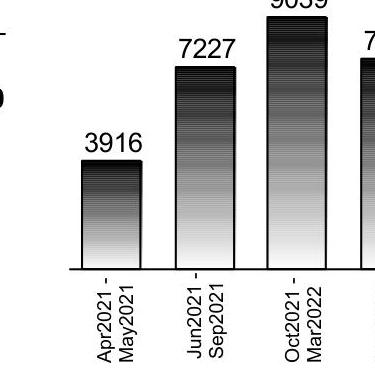

In [ ]:
response.model_dump()

In [ ]:
def display_base64_image(base64_string):
    """Display base64 image, handling data URL prefixes"""
    try:
        # Remove data URL prefix if present
        if base64_string.startswith('data:image'):
            base64_string = base64_string.split(',')[1]
        
        # Decode base64
        image_data = base64.b64decode(base64_string)
        
        # Open as PIL Image
        pil_image = Image.open(BytesIO(image_data))
        
        # Display
        display(pil_image)
        return pil_image
        
    except Exception as e:
        print(f"Error displaying image: {e}")
        return None

In [ ]:
from PIL import Image
from io import BytesIO
from IPython.display import display

for page in ocr_response.response.pages:
    for image in page.images:
        display_base64_image(image.image_base64)
  

AttributeError: 'OCRResponse' object has no attribute 'response'